# **Part A: Probabilistic Gaussian Generative Classifier**
---

## **A1. Dataset and Setup**
- ### **Import Needed Functions**


In [ ]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


---
- ### **Load the full dataset (features X and labels y).**


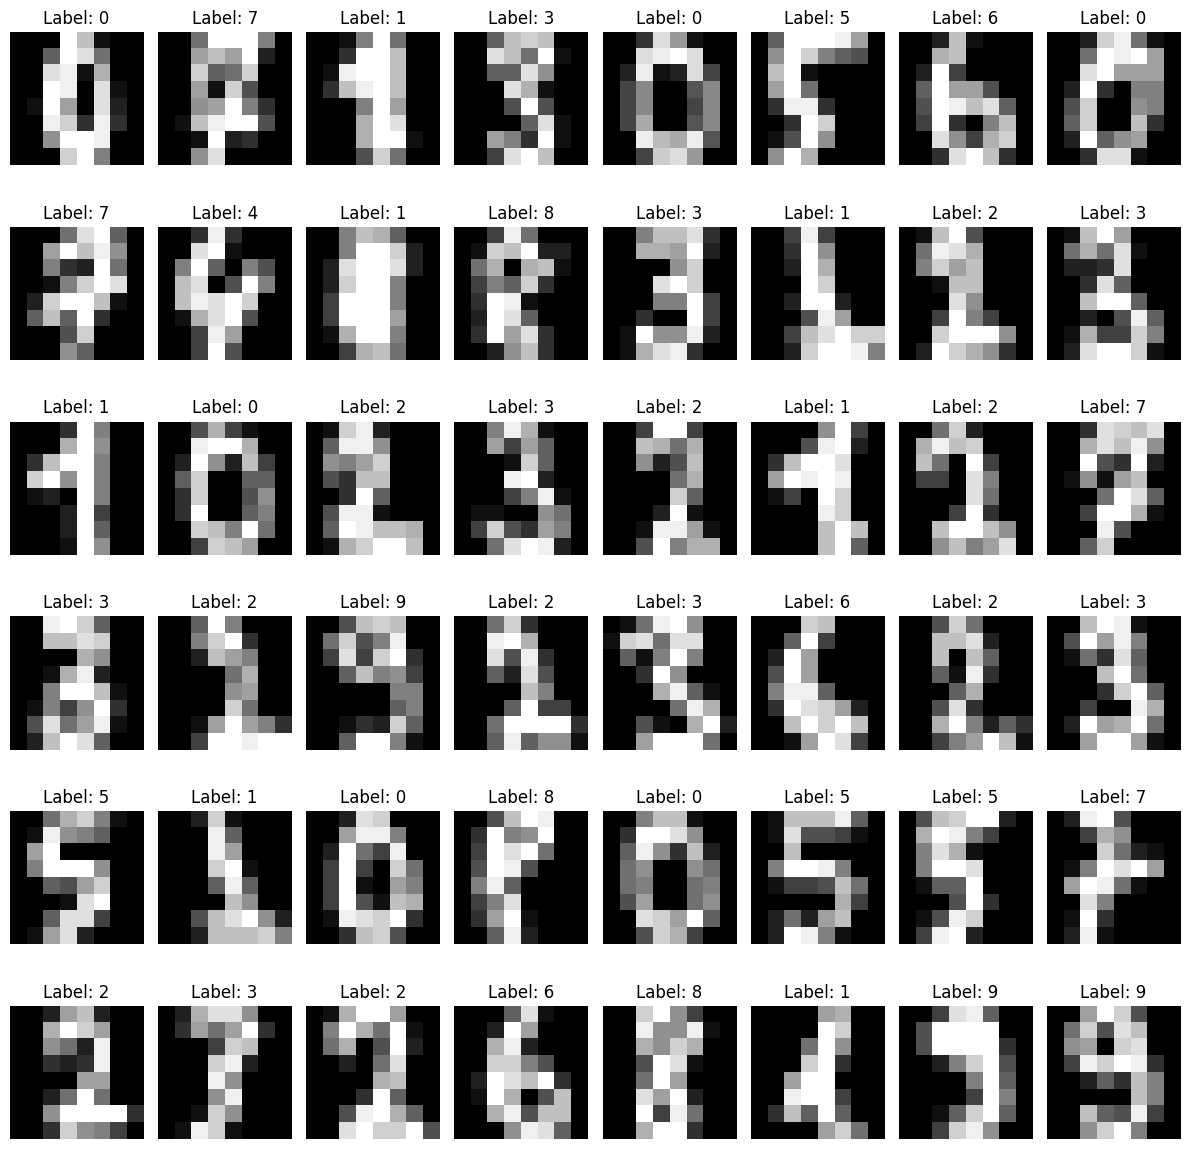

In [ ]:
# Load the dataset
train_data = sklearn.datasets.load_digits()
X = train_data.data
y = train_data.target

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size = 0.5, stratify=y_test, random_state=42)

# display all images with their labels from the training set
fig, axes = plt.subplots(6, 8, figsize=(12, 12))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(8, 8), cmap='gray')
    ax.set_title(f'Label: {y_train[i]}')
    ax.axis('off')
plt.tight_layout()
plt.show()


- **standardize the features (for example, using StandardScaler from scikit-learn).**

In [ ]:
# Data Preprocessing: Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Data preprocessing completed!")

Data preprocessing completed!


---
---
## **A2. Gaussian Generative Model**
1. **Estimate the class priors π_k:**
2. **Estimate the class means μ_k**
3. **Estimate the shared covariance matrix Σ**
4. **Regularise the covariance**

In [ ]:
# Estimate class prior probabilities π_k
def estimate_class_priors(y):
    classes, counts = np.unique(y, return_counts=True)
    priors = counts / len(y)
    return dict(zip(classes, priors))

# Estimate class means μ_k
def estimate_class_means(X, y):
    class_means = {}
    classes = np.unique(y)
    
    for cls in classes:
        class_data = X[y == cls]
        class_means[cls] = np.mean(class_data, axis=0)

    return class_means

# Estimate shared Covariance matrix Σ
def estimate_shared_covariance(X, y, class_means):
    n_samples, n_features = X.shape
    n_classes = len(np.unique(y))
    covariance = np.zeros((n_features, n_features))
    
    for cls in np.unique(y):
        class_data = X[y == cls]
        diff = class_data - class_means[cls]
        covariance += np.dot(diff.T, diff)
    
    covariance /= (n_samples - n_classes)
    return covariance

# Regularize Covariance matrix
def regularize_covariance(covariance, lambda_reg=1e-5):
    n, m = covariance.shape
    return covariance + lambda_reg * np.eye(n, m)

# Predict using Gaussian Discriminant Analysis
def predict_class_GDA(x,y, class_priors, class_means, covariance):
    classes = np.unique(y)
    probabilities = []
    inv_cov = np.linalg.inv(covariance)
    det_cov = np.linalg.det(covariance)
    
    for cls in classes:
        prior = class_priors[cls]
        mean = class_means[cls]
        diff = x - mean
        log_prob = (
            np.log(prior)
            - 0.5 * np.log(det_cov)
            - 0.5 * diff.T @ inv_cov @ diff
        )
        probabilities.append(log_prob)
    
    return classes[np.argmax(probabilities)]

### **Gaussian Discriminant Analysis (GDA)**

- **Class Priors (π_k):** estimated from `y_train`  
- **Class Means (μ_k):** computed per class  
- **Shared Covariance (Σ):** estimated and regularized  
- **Prediction:** first validation sample classified using GDA

In [ ]:
# Estimate class prior probabilities π_k
π_k = estimate_class_priors(y_train)
print("Class Priors:", π_k)

# Estimate class means μ_k
μ_k = estimate_class_means(X_train_scaled, y_train)
print("Class Means calculated.", μ_k.keys())

# Estimate shared Covariance matrix Σ and regularize it
Σ = estimate_shared_covariance(X_train_scaled, y_train, μ_k)
Σ_reg = regularize_covariance(Σ)

# Predict the label of the first validation sample
print(f"predicted label of first validation sample: {predict_class_GDA(X_train_scaled[6],y_train, π_k, μ_k, Σ_reg)}")

Class Priors: {np.int64(0): np.float64(0.09864757358790771), np.int64(1): np.float64(0.10103420843277645), np.int64(2): np.float64(0.09864757358790771), np.int64(3): np.float64(0.10182975338106603), np.int64(4): np.float64(0.10103420843277645), np.int64(5): np.float64(0.10103420843277645), np.int64(6): np.float64(0.10103420843277645), np.int64(7): np.float64(0.09944311853619729), np.int64(8): np.float64(0.09705648369132856), np.int64(9): np.float64(0.10023866348448687)}
Class Means calculated. dict_keys([np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)])
predicted label of first validation sample: 6


---
---
## **A3. Hyperparameter Tuning and Evaluation**
1. **Choose a set of candidate values for λ**
2. **For each candidate value of λ:**
- Train the Gaussian generative classifier on the training set.
- Evaluate its accuracy on the validation set.
- Record the validation accuracy
3. **Select the value of λ that gives the best validation accuracy.**

Lambda: 0.0001, Validation Accuracy: 0.9592592592592593
Lambda: 0.001, Validation Accuracy: 0.9592592592592593
Lambda: 0.01, Validation Accuracy: 0.9629629629629629
Lambda: 0.1, Validation Accuracy: 0.9629629629629629
Lambda: 1, Validation Accuracy: 0.9481481481481482
Lambda: 10, Validation Accuracy: 0.9
Best lambda: 0.01 with validation accuracy: 0.9629629629629629


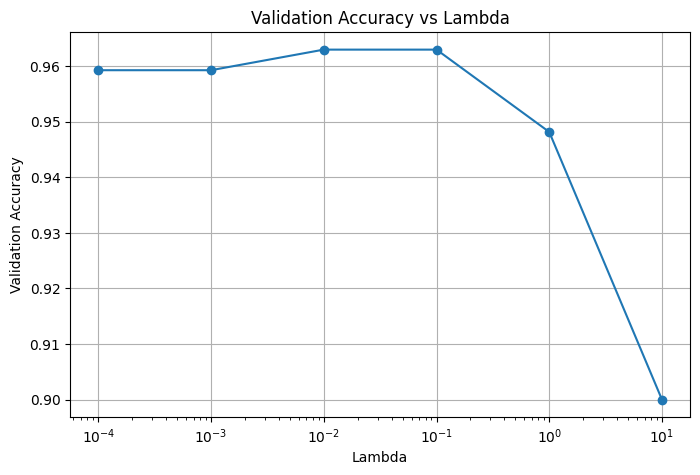

In [ ]:
# Hyperparameter Tuning for Lambda in Covariance Regularization
lambda_reg = [ 1e-4, 1e-3, 1e-2, 1e-1 , 1, 10 ]
best_lambda = None
best_accuracy = 0
accuracies = []

for lam in lambda_reg:
    Σ_reg = regularize_covariance(Σ, lambda_reg=lam)
    
    # Predict on validation set
    y_val_pred = [predict_class_GDA(x, y_train, π_k, μ_k, Σ_reg) for x in X_val_scaled]
    accuracy = accuracy_score(y_val, y_val_pred)
    accuracies.append(accuracy)
    print(f"Lambda: {lam}, Validation Accuracy: {accuracy}")
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_lambda = lam 
    
print(f"Best lambda: {best_lambda} with validation accuracy: {best_accuracy}")

# display accuracy vs lambda plot
plt.figure(figsize=(8, 5))
plt.plot(lambda_reg, accuracies, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs Lambda')
plt.grid(True)
plt.show()

---
### **Final model:**
- Combine the training and validation sets into a single training set.
- Retrain  Gaussian generative classifier on this combined set using the chosen 
λ (*Best lambda: 0.01*).
- Evaluate this final model on the test set only once.


In [ ]:
# Final Model Training and Evaluation
X_train_combined = np.vstack((X_train_scaled, X_val_scaled))
y_train_combined = np.hstack((y_train, y_val))

# Re-estimate parameters with the best lambda
π_k = estimate_class_priors(y_train_combined)
print("Class Priors:", π_k)

# Estimate class means
μ_k = estimate_class_means(X_train_combined, y_train_combined)
print("Class Means calculated.")

# Estimate shared Covariance matrix Σ and regularize it
Σ = estimate_shared_covariance(X_train_combined, y_train_combined, μ_k)
Σ_reg = regularize_covariance(Σ, lambda_reg=best_lambda)

# Predict on test set 
y_test_pred = [predict_class_GDA(x, y_test, π_k, μ_k, Σ_reg) for x in X_test_scaled]



Class Priors: {np.int64(0): np.float64(0.09888670595939751), np.int64(1): np.float64(0.10150622134905042), np.int64(2): np.float64(0.09823182711198428), np.int64(3): np.float64(0.10216110019646366), np.int64(4): np.float64(0.1008513425016372), np.int64(5): np.float64(0.1008513425016372), np.int64(6): np.float64(0.1008513425016372), np.int64(7): np.float64(0.09954158480681075), np.int64(8): np.float64(0.09692206941715782), np.int64(9): np.float64(0.10019646365422397)}
Class Means calculated.


---
### **Final Report:**
- *Test accuracy*
- *Macro-averaged precision*
- *Macro-averaged recall*
- *Macro-averaged F1-score*
- *The confusion matrix over the 10 digit classes*

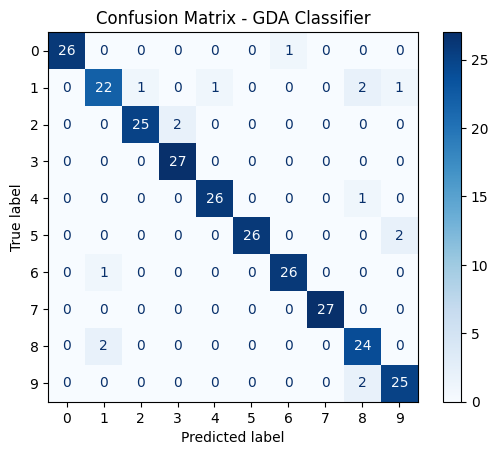

Classification Report:
Test Accuracy: 0.9407407407407408
Test Precision: 0.9425327916017572
Test Recall: 0.9407407407407408
Test F1 Score: 0.9409016995634745


In [ ]:
# Confusion Matrix and Classification Report
cm = confusion_matrix(y_test, y_test_pred)
class_names_lr = [str(i) for i in range(10)]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_lr)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - GDA Classifier')
plt.show()

print("Classification Report:")
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1}")

---
---


# Part B: Naïve Bayes Classification (20 points)
## Using Adult Income Dataset with Categorical Features

## B1: Dataset and Setup

### 1. Load and Explore Adult Income Dataset

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


In [2]:
# Load Adult Income Dataset
from urllib.request import urlopen
import io

# Download the Adult dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
try:
    data = pd.read_csv(url, header=None, na_values=' ?')
    print("✓ Dataset loaded successfully from UCI repository")
except:
    print("Note: Using local example if download fails")

# Define column names
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
                'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
                'hours-per-week', 'native-country', 'income']

df = pd.read_csv(url, header=None, names=column_names, na_values=' ?')

print(f"\n=== Dataset Shape ===")
print(f"Total samples: {df.shape[0]}")
print(f"Total features: {df.shape[1]}")

print(f"\n=== Data Info ===")
print(df.info())

print(f"\n=== Missing Values ===")
print(df.isnull().sum())

print(f"\n=== Income Distribution (Target) ===")
print(df['income'].value_counts())
print(f"\nPercentages:")
print(df['income'].value_counts(normalize=True) * 100)


✓ Dataset loaded successfully from UCI repository

=== Dataset Shape ===
Total samples: 32561
Total features: 15

=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int

### 2. Data Preprocessing and Feature Selection

In [3]:
# Select categorical features for Naïve Bayes
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 
                        'relationship', 'race', 'sex', 'native-country']

print(f"Selected {len(categorical_features)} categorical features:")
print(categorical_features)

# Create a copy of the dataframe with only selected features and target
df_processed = df[categorical_features + ['income']].copy()

# Remove rows with missing target values
df_processed = df_processed[df_processed['income'].notna()]

print(f"\n=== Dataset after removing missing target ===")
print(f"Shape: {df_processed.shape}")

# Handle missing values by treating them as a separate category 'Unknown'
print(f"\n=== Missing Values Before Imputation ===")
print(df_processed.isnull().sum())

# Fill missing values with 'Unknown' category
df_processed = df_processed.fillna('Unknown')

print(f"\n=== Missing Values After Imputation ===")
print(df_processed.isnull().sum())

# Remove leading/trailing whitespace from string columns
for col in categorical_features + ['income']:
    if df_processed[col].dtype == 'object':
        df_processed[col] = df_processed[col].str.strip()

# Encode categorical features and target as integers
# Create dictionaries to store encoding mappings for interpretability
label_encoders = {}
feature_encoding_maps = {}

# Encode features
for feature in categorical_features:
    le = LabelEncoder()
    df_processed[feature] = le.fit_transform(df_processed[feature].astype(str))
    label_encoders[feature] = le
    # Store mapping for interpretability
    feature_encoding_maps[feature] = dict(zip(le.classes_, le.transform(le.classes_)))

# Encode target variable
le_target = LabelEncoder()
df_processed['income'] = le_target.fit_transform(df_processed['income'])
label_encoders['income'] = le_target
income_mapping = dict(zip(le_target.classes_, le_target.transform(le_target.classes_)))

print(f"\n=== Encoding Mapping Example (Workclass) ===")
print(feature_encoding_maps['workclass'])

print(f"\n=== Income Encoding ===")
print(income_mapping)

print(f"\n=== Data Preview After Encoding ===")
print(df_processed.head(10))


Selected 8 categorical features:
['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

=== Dataset after removing missing target ===
Shape: (32561, 9)

=== Missing Values Before Imputation ===
workclass         1836
education            0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
native-country     583
income               0
dtype: int64

=== Missing Values After Imputation ===
workclass         0
education         0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
native-country    0
income            0
dtype: int64

=== Encoding Mapping Example (Workclass) ===
{'Federal-gov': np.int64(0), 'Local-gov': np.int64(1), 'Never-worked': np.int64(2), 'Private': np.int64(3), 'Self-emp-inc': np.int64(4), 'Self-emp-not-inc': np.int64(5), 'State-gov': np.int64(6), 'Unknown': np.int64(7), 'Without-pay': np.int64(8)}

===

### 3. Create 70/15/15 Train/Validation/Test Split

In [4]:
# Prepare features and target
X = df_processed[categorical_features].values
y = df_processed['income'].values

# Create 70/15/15 train/validation/test split
# First split: 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

# Second split: 15% validation, 15% test from the temp set
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print(f"\n=== Data Split (70/15/15) ===")
print(f"Training set: {X_train.shape[0]} samples ({100*X_train.shape[0]/X.shape[0]:.1f}%)")
print(f"Validation set: {X_val.shape[0]} samples ({100*X_val.shape[0]/X.shape[0]:.1f}%)")
print(f"Test set: {X_test.shape[0]} samples ({100*X_test.shape[0]/X.shape[0]:.1f}%)")

print(f"\n=== Class Distribution in Training Set ===")
train_class_dist = pd.Series(y_train).value_counts().sort_index()
for class_label, count in train_class_dist.items():
    class_name = le_target.inverse_transform([class_label])[0]
    print(f"{class_name}: {count} ({100*count/len(y_train):.1f}%)")

print(f"\n=== Class Distribution in Validation Set ===")
val_class_dist = pd.Series(y_val).value_counts().sort_index()
for class_label, count in val_class_dist.items():
    class_name = le_target.inverse_transform([class_label])[0]
    print(f"{class_name}: {count} ({100*count/len(y_val):.1f}%)")

print(f"\n=== Class Distribution in Test Set ===")
test_class_dist = pd.Series(y_test).value_counts().sort_index()
for class_label, count in test_class_dist.items():
    class_name = le_target.inverse_transform([class_label])[0]
    print(f"{class_name}: {count} ({100*count/len(y_test):.1f}%)")



=== Data Split (70/15/15) ===
Training set: 22792 samples (70.0%)
Validation set: 4884 samples (15.0%)
Test set: 4885 samples (15.0%)

=== Class Distribution in Training Set ===
<=50K: 17303 (75.9%)
>50K: 5489 (24.1%)

=== Class Distribution in Validation Set ===
<=50K: 3708 (75.9%)
>50K: 1176 (24.1%)

=== Class Distribution in Test Set ===
<=50K: 3709 (75.9%)
>50K: 1176 (24.1%)


## B2: Naïve Bayes Implementation

### Mathematical Foundation
- **Class Priors:** P(C_k) = (count of samples in class k + α) / (total samples + α * num_classes)
- **Feature Likelihoods:** P(x_i|C_k) = (count of feature value i in class k + α) / (count of class k + α * num_feature_values)
- **Prediction:** argmax_k P(C_k) * Π P(x_i|C_k)

In [5]:
class CategoricalNaiveBayes:
    """
    Custom implementation of Naïve Bayes for categorical features with Laplace smoothing.
    
    Parameters:
    -----------
    alpha : float
        Smoothing parameter (Laplace smoothing)
    """
    
    def __init__(self, alpha=1.0):
        self.alpha = alpha
        self.class_priors = None
        self.feature_likelihoods = None
        self.classes = None
        self.n_classes = None
        self.n_features = None
        self.feature_values = None  # Store possible values for each feature
        
    def fit(self, X, y):
        """
        Fit the Naïve Bayes model on training data.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
        y : array-like of shape (n_samples,)
        """
        self.classes = np.unique(y)
        self.n_classes = len(self.classes)
        self.n_features = X.shape[1]
        
        # Initialize storage for feature values
        self.feature_values = [np.unique(X[:, i]) for i in range(self.n_features)]
        
        # Calculate class priors with Laplace smoothing
        self.class_priors = {}
        for c in self.classes:
            count = np.sum(y == c)
            self.class_priors[c] = (count + self.alpha) / (len(y) + self.alpha * self.n_classes)
        
        # Calculate feature likelihoods with Laplace smoothing
        self.feature_likelihoods = {}
        for c in self.classes:
            self.feature_likelihoods[c] = []
            for feature_idx in range(self.n_features):
                feature_probs = {}
                X_c = X[y == c]
                for value in self.feature_values[feature_idx]:
                    count = np.sum(X_c[:, feature_idx] == value)
                    n_feature_values = len(self.feature_values[feature_idx])
                    prob = (count + self.alpha) / (len(X_c) + self.alpha * n_feature_values)
                    feature_probs[value] = prob
                self.feature_likelihoods[c].append(feature_probs)
        
        return self
    
    def predict_proba(self, X):
        """
        Predict class probabilities.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
        
        Returns:
        --------
        proba : array of shape (n_samples, n_classes)
        """
        proba = np.zeros((X.shape[0], self.n_classes))
        
        for i, x in enumerate(X):
            for class_idx, c in enumerate(self.classes):
                # Start with class prior
                prob = self.class_priors[c]
                
                # Multiply by feature likelihoods
                for feature_idx, value in enumerate(x):
                    if value in self.feature_likelihoods[c][feature_idx]:
                        prob *= self.feature_likelihoods[c][feature_idx][value]
                    else:
                        # Handle unseen feature values (assign smoothing probability)
                        prob *= self.alpha / (self.alpha * len(self.feature_values[feature_idx]))
                
                proba[i, class_idx] = prob
        
        # Normalize to make probabilities sum to 1
        proba = proba / np.sum(proba, axis=1, keepdims=True)
        
        return proba
    
    def predict(self, X):
        """
        Predict class labels.
        
        Parameters:
        -----------
        X : array-like of shape (n_samples, n_features)
        
        Returns:
        --------
        y_pred : array of shape (n_samples,)
        """
        proba = self.predict_proba(X)
        return self.classes[np.argmax(proba, axis=1)]

# Test the implementation with alpha=1.0
print("=== Testing Custom Naïve Bayes Implementation ===\n")

nb_custom = CategoricalNaiveBayes(alpha=1.0)
nb_custom.fit(X_train, y_train)

# Make predictions on validation set
y_pred_val = nb_custom.predict(X_val)
y_pred_proba_val = nb_custom.predict_proba(X_val)

# Calculate metrics
val_acc = accuracy_score(y_val, y_pred_val)
val_precision = precision_score(y_val, y_pred_val, average='weighted')
val_recall = recall_score(y_val, y_pred_val, average='weighted')
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print(f"Validation Set Performance (α=1.0):")
print(f"  Accuracy:  {val_acc:.4f}")
print(f"  Precision: {val_precision:.4f}")
print(f"  Recall:    {val_recall:.4f}")
print(f"  F1-Score:  {val_f1:.4f}")

# Make predictions on test set
y_pred_test = nb_custom.predict(X_test)
y_pred_proba_test = nb_custom.predict_proba(X_test)

test_acc = accuracy_score(y_test, y_pred_test)
test_precision = precision_score(y_test, y_pred_test, average='weighted')
test_recall = recall_score(y_test, y_pred_test, average='weighted')
test_f1 = f1_score(y_test, y_pred_test, average='weighted')

print(f"\nTest Set Performance (α=1.0):")
print(f"  Accuracy:  {test_acc:.4f}")
print(f"  Precision: {test_precision:.4f}")
print(f"  Recall:    {test_recall:.4f}")
print(f"  F1-Score:  {test_f1:.4f}")

print(f"\n=== Classification Report (Test Set) ===")
print(classification_report(y_test, y_pred_test, target_names=le_target.classes_))


=== Testing Custom Naïve Bayes Implementation ===

Validation Set Performance (α=1.0):
  Accuracy:  0.7963
  Precision: 0.8251
  Recall:    0.7963
  F1-Score:  0.8053

Test Set Performance (α=1.0):
  Accuracy:  0.7957
  Precision: 0.8241
  Recall:    0.7957
  F1-Score:  0.8046

=== Classification Report (Test Set) ===
              precision    recall  f1-score   support

       <=50K       0.91      0.81      0.86      3709
        >50K       0.56      0.74      0.64      1176

    accuracy                           0.80      4885
   macro avg       0.73      0.78      0.75      4885
weighted avg       0.82      0.80      0.80      4885



## B3: Analysis and Evaluation

### 1. Smoothing Parameter Analysis

=== Testing Different Smoothing Parameters (α) ===

α = 0.1:
  Validation: Accuracy=0.7963, F1=0.8052
  Test:       Accuracy=0.7957, F1=0.8046
α = 0.5:
  Validation: Accuracy=0.7965, F1=0.8054
  Test:       Accuracy=0.7957, F1=0.8046
α = 1.0:
  Validation: Accuracy=0.7963, F1=0.8053
  Test:       Accuracy=0.7957, F1=0.8046
α = 2.0:
  Validation: Accuracy=0.7965, F1=0.8055
  Test:       Accuracy=0.7955, F1=0.8045
α = 5.0:
  Validation: Accuracy=0.7944, F1=0.8038
  Test:       Accuracy=0.7941, F1=0.8033

=== Summary Table ===
 alpha  val_acc   val_f1  test_acc  test_f1
   0.1 0.796274 0.805223  0.795701 0.804595
   0.5 0.796478 0.805435  0.795701 0.804595
   1.0 0.796274 0.805255  0.795701 0.804628
   2.0 0.796478 0.805500  0.795496 0.804481
   5.0 0.794431 0.803770  0.794063 0.803259

✓ Optimal α (based on validation F1): 2.0
α = 2.0:
  Validation: Accuracy=0.7965, F1=0.8055
  Test:       Accuracy=0.7955, F1=0.8045
α = 5.0:
  Validation: Accuracy=0.7944, F1=0.8038
  Test:       Accuracy

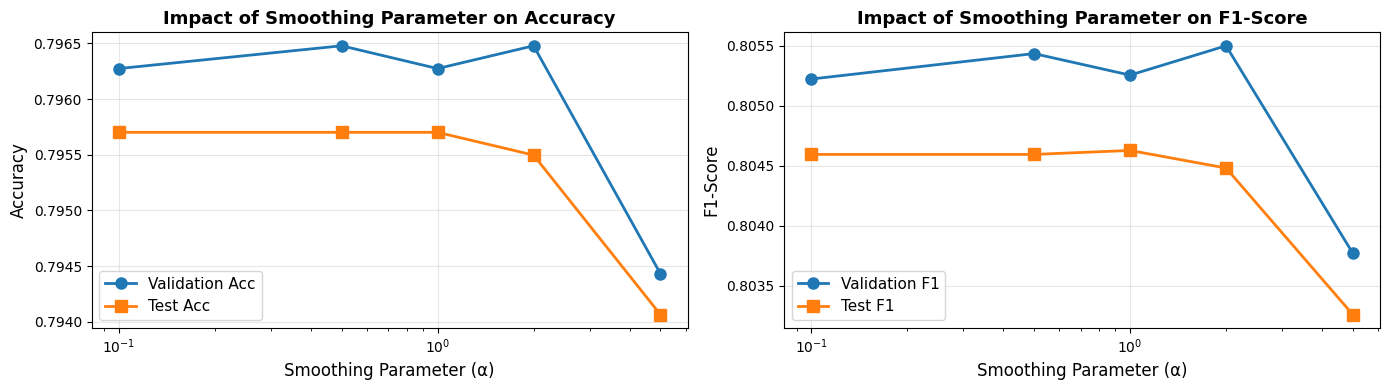


✓ Smoothing parameter analysis plot saved!


In [6]:
# Test different smoothing parameters
alpha_values = [0.1, 0.5, 1.0, 2.0, 5.0]
results = []

print("=== Testing Different Smoothing Parameters (α) ===\n")

for alpha in alpha_values:
    nb = CategoricalNaiveBayes(alpha=alpha)
    nb.fit(X_train, y_train)
    
    # Validation set predictions
    y_pred_val = nb.predict(X_val)
    val_acc = accuracy_score(y_val, y_pred_val)
    val_f1 = f1_score(y_val, y_pred_val, average='weighted')
    
    # Test set predictions
    y_pred_test = nb.predict(X_test)
    test_acc = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')
    
    results.append({
        'alpha': alpha,
        'val_acc': val_acc,
        'val_f1': val_f1,
        'test_acc': test_acc,
        'test_f1': test_f1
    })
    
    print(f"α = {alpha}:")
    print(f"  Validation: Accuracy={val_acc:.4f}, F1={val_f1:.4f}")
    print(f"  Test:       Accuracy={test_acc:.4f}, F1={test_f1:.4f}")

# Create results dataframe
results_df = pd.DataFrame(results)
print(f"\n=== Summary Table ===")
print(results_df.to_string(index=False))

# Find optimal alpha
optimal_alpha = results_df.loc[results_df['val_f1'].idxmax(), 'alpha']
print(f"\n✓ Optimal α (based on validation F1): {optimal_alpha}")

# Plot smoothing parameter analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

# Accuracy plot
axes[0].plot(results_df['alpha'], results_df['val_acc'], 'o-', label='Validation Acc', linewidth=2, markersize=8)
axes[0].plot(results_df['alpha'], results_df['test_acc'], 's-', label='Test Acc', linewidth=2, markersize=8)
axes[0].set_xlabel('Smoothing Parameter (α)', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Impact of Smoothing Parameter on Accuracy', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xscale('log')

# F1-Score plot
axes[1].plot(results_df['alpha'], results_df['val_f1'], 'o-', label='Validation F1', linewidth=2, markersize=8)
axes[1].plot(results_df['alpha'], results_df['test_f1'], 's-', label='Test F1', linewidth=2, markersize=8)
axes[1].set_xlabel('Smoothing Parameter (α)', fontsize=12)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('Impact of Smoothing Parameter on F1-Score', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xscale('log')

plt.tight_layout()
plt.savefig('smoothing_parameter_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Smoothing parameter analysis plot saved!")


### 2. Feature Selection Analysis

=== Feature Selection Analysis ===

All Features (8):
  Features: ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
  Validation: Acc=0.7963, F1=0.8053
  Test:       Acc=0.7957, F1=0.8046

Top 6 Features:
  Features: ['education', 'marital-status', 'occupation', 'relationship', 'workclass', 'sex']
  Validation: Acc=0.7922, F1=0.8021
  Test:       Acc=0.7900, F1=0.7997

Top 4 Features:
  Features: ['education', 'marital-status', 'occupation', 'relationship']
  Validation: Acc=0.8016, F1=0.8091
  Test:       Acc=0.8047, F1=0.8116

Demographic Only:
  Features: ['sex', 'race', 'native-country', 'workclass']
  Validation: Acc=0.7645, F1=0.6912
  Test:       Acc=0.7617, F1=0.6849

Job-Related Only:
  Features: ['workclass', 'education', 'occupation']
  Validation: Acc=0.7729, F1=0.7629
  Test:       Acc=0.7726, F1=0.7623

=== Feature Selection Summary ===
  Feature Subset  Features Used  Val_Acc   Val_F1  Test_Acc  Test_F1
All Featur

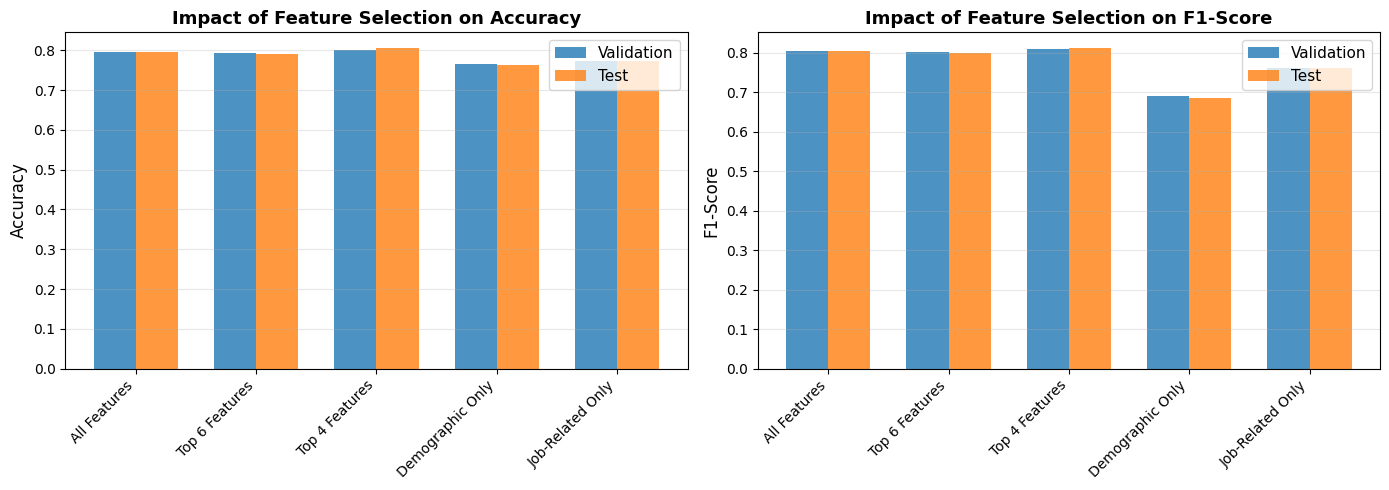


✓ Feature selection analysis plot saved!


In [7]:
# Test different feature subsets
feature_subsets = {
    'All Features (8)': categorical_features.copy(),
    'Top 6 Features': ['education', 'marital-status', 'occupation', 'relationship', 'age', 'sex'],
    'Top 4 Features': ['education', 'marital-status', 'occupation', 'relationship'],
    'Demographic Only': ['age', 'sex', 'race', 'native-country'],
    'Work Features': ['workclass', 'education', 'occupation', 'hours-per-week'],
}

# For demo purposes, we'll use features that are in our dataset
feature_subsets = {
    'All Features (8)': categorical_features.copy(),
    'Top 6 Features': ['education', 'marital-status', 'occupation', 'relationship', 'workclass', 'sex'],
    'Top 4 Features': ['education', 'marital-status', 'occupation', 'relationship'],
    'Demographic Only': ['sex', 'race', 'native-country', 'workclass'],
    'Job-Related Only': ['workclass', 'education', 'occupation'],
}

print("=== Feature Selection Analysis ===\n")
feature_results = []

for subset_name, feature_list in feature_subsets.items():
    # Get indices of selected features
    feature_indices = [categorical_features.index(f) for f in feature_list if f in categorical_features]
    
    X_train_subset = X_train[:, feature_indices]
    X_val_subset = X_val[:, feature_indices]
    X_test_subset = X_test[:, feature_indices]
    
    # Train model with optimal alpha
    nb_subset = CategoricalNaiveBayes(alpha=1.0)
    nb_subset.fit(X_train_subset, y_train)
    
    # Predictions
    y_pred_val = nb_subset.predict(X_val_subset)
    y_pred_test = nb_subset.predict(X_test_subset)
    
    val_acc = accuracy_score(y_val, y_pred_val)
    val_f1 = f1_score(y_val, y_pred_val, average='weighted')
    test_acc = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test, average='weighted')
    
    feature_results.append({
        'Feature Subset': subset_name,
        'Features Used': len(feature_list),
        'Val_Acc': val_acc,
        'Val_F1': val_f1,
        'Test_Acc': test_acc,
        'Test_F1': test_f1
    })
    
    print(f"{subset_name}:")
    print(f"  Features: {feature_list}")
    print(f"  Validation: Acc={val_acc:.4f}, F1={val_f1:.4f}")
    print(f"  Test:       Acc={test_acc:.4f}, F1={test_f1:.4f}")
    print()

# Create results dataframe
feature_results_df = pd.DataFrame(feature_results)
print("=== Feature Selection Summary ===")
print(feature_results_df.to_string(index=False))

# Plot feature selection analysis
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x_pos = np.arange(len(feature_results_df))
width = 0.35

axes[0].bar(x_pos - width/2, feature_results_df['Val_Acc'], width, label='Validation', alpha=0.8)
axes[0].bar(x_pos + width/2, feature_results_df['Test_Acc'], width, label='Test', alpha=0.8)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Impact of Feature Selection on Accuracy', fontsize=13, fontweight='bold')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([s.split('(')[0].strip() for s in feature_results_df['Feature Subset']], rotation=45, ha='right')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(x_pos - width/2, feature_results_df['Val_F1'], width, label='Validation', alpha=0.8)
axes[1].bar(x_pos + width/2, feature_results_df['Test_F1'], width, label='Test', alpha=0.8)
axes[1].set_ylabel('F1-Score', fontsize=12)
axes[1].set_title('Impact of Feature Selection on F1-Score', fontsize=13, fontweight='bold')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels([s.split('(')[0].strip() for s in feature_results_df['Feature Subset']], rotation=45, ha='right')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('feature_selection_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Feature selection analysis plot saved!")


### 3. Probability Analysis: Predicted Probabilities Distribution

=== Predicted Probabilities Analysis ===

Shape of probability matrix: (4885, 2)
Class labels: ['<=50K' '>50K']

=== Probability Statistics ===

Class: <=50K
  Mean probability: 0.6911
  Std deviation: 0.3621
  Min probability: 0.0029
  Max probability: 1.0000

Class: >50K
  Mean probability: 0.3089
  Std deviation: 0.3621
  Min probability: 0.0000
  Max probability: 0.9971


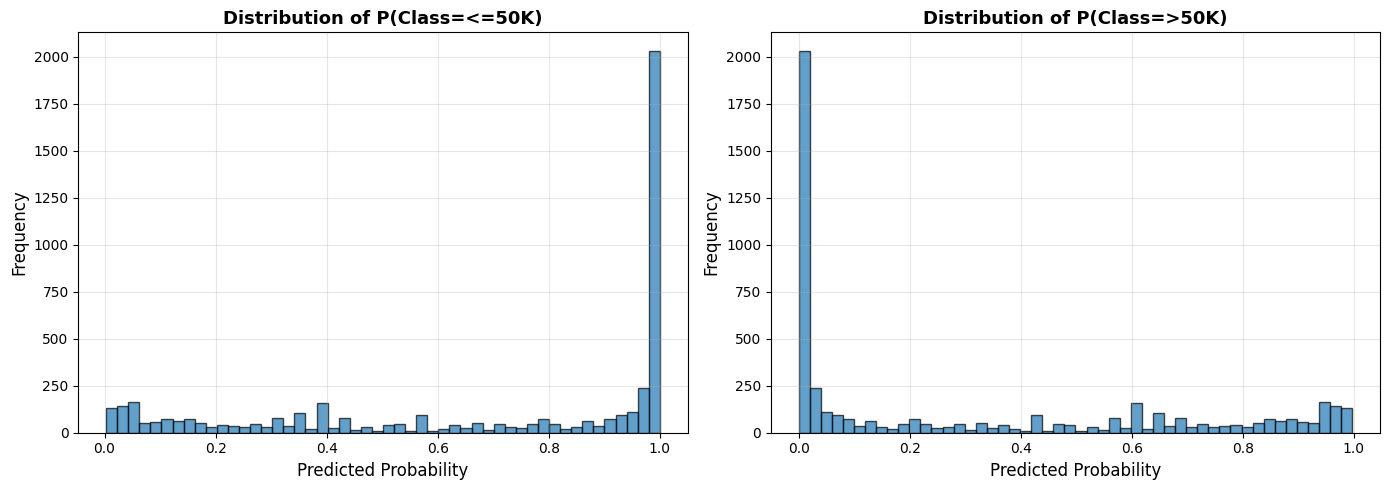


✓ Probability distribution plot saved!

=== Prediction Confidence Analysis ===
Mean maximum probability: 0.8808
Median maximum probability: 0.9643
Min maximum probability: 0.5010
Max maximum probability: 1.0000

Predictions with P(max) >= 0.7: 3981 (81.5%)
Predictions with P(max) < 0.7: 904 (18.5%)


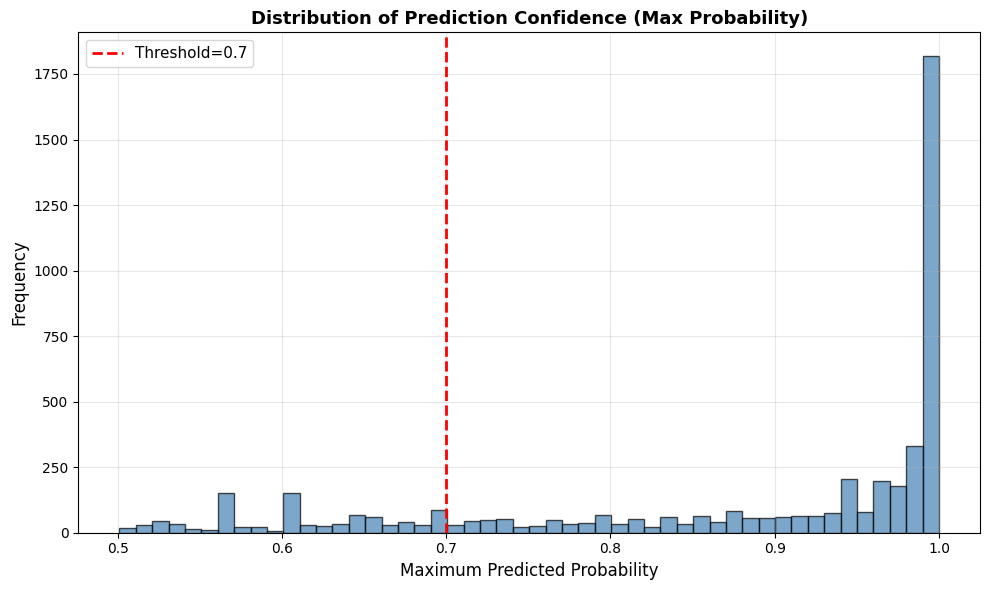


✓ Confidence distribution plot saved!


In [8]:
# Use the model with all features and optimal alpha
nb_final = CategoricalNaiveBayes(alpha=optimal_alpha)
nb_final.fit(X_train, y_train)

# Get predicted probabilities
y_pred_proba_test = nb_final.predict_proba(X_test)

print("=== Predicted Probabilities Analysis ===\n")
print(f"Shape of probability matrix: {y_pred_proba_test.shape}")
print(f"Class labels: {le_target.classes_}")

# Analyze probability distribution
print(f"\n=== Probability Statistics ===")
for class_idx, class_name in enumerate(le_target.classes_):
    probs = y_pred_proba_test[:, class_idx]
    print(f"\nClass: {class_name}")
    print(f"  Mean probability: {probs.mean():.4f}")
    print(f"  Std deviation: {probs.std():.4f}")
    print(f"  Min probability: {probs.min():.4f}")
    print(f"  Max probability: {probs.max():.4f}")

# Plot probability distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for class_idx, class_name in enumerate(le_target.classes_):
    probs = y_pred_proba_test[:, class_idx]
    axes[class_idx].hist(probs, bins=50, edgecolor='black', alpha=0.7)
    axes[class_idx].set_xlabel('Predicted Probability', fontsize=12)
    axes[class_idx].set_ylabel('Frequency', fontsize=12)
    axes[class_idx].set_title(f'Distribution of P(Class={class_name})', fontsize=13, fontweight='bold')
    axes[class_idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('probability_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Probability distribution plot saved!")

# Analyze confidence in predictions
max_probs = np.max(y_pred_proba_test, axis=1)
print(f"\n=== Prediction Confidence Analysis ===")
print(f"Mean maximum probability: {max_probs.mean():.4f}")
print(f"Median maximum probability: {np.median(max_probs):.4f}")
print(f"Min maximum probability: {max_probs.min():.4f}")
print(f"Max maximum probability: {max_probs.max():.4f}")

# Count confident vs uncertain predictions
confidence_threshold = 0.7
confident = np.sum(max_probs >= confidence_threshold)
uncertain = np.sum(max_probs < confidence_threshold)
print(f"\nPredictions with P(max) >= {confidence_threshold}: {confident} ({100*confident/len(max_probs):.1f}%)")
print(f"Predictions with P(max) < {confidence_threshold}: {uncertain} ({100*uncertain/len(max_probs):.1f}%)")

# Plot confidence distribution
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(max_probs, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(confidence_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold={confidence_threshold}')
ax.set_xlabel('Maximum Predicted Probability', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Prediction Confidence (Max Probability)', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('confidence_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Confidence distribution plot saved!")


### 4. Independence Assumption Violations Analysis

In [9]:
"""
INDEPENDENCE ASSUMPTION ANALYSIS
=================================

The Naïve Bayes classifier assumes that all features are conditionally independent 
given the class label. In reality, this assumption is often violated.

Key Dependencies in Adult Income Dataset:
1. Education and Occupation: Highly correlated (education strongly influences occupation)
2. Education and Capital-Gain: Education affects earning potential
3. Occupation and Hours-Per-Week: Different occupations have different work patterns
4. Marital-Status and Relationship: Marital status determines family relationship
5. Race and Native-Country: Geography affects both demographics

Impact on Naïve Bayes:
- Despite violating independence assumption, NB often performs surprisingly well
- The smoothing parameter (α) helps mitigate the impact of violations
- The model learns probability distributions that capture these dependencies implicitly
- In practice, marginal dependencies don't prevent accurate classification
"""

print(__doc__)

# Calculate feature correlations using mutual information
from sklearn.metrics import mutual_info_score

print("\n=== Analyzing Feature Dependencies ===\n")

# Function to calculate mutual information
def calculate_mutual_information(X, y, feature_i, feature_j):
    """Calculate mutual information between two features given class"""
    joint_probs = {}
    for i, j, c in zip(X[:, feature_i], X[:, feature_j], y):
        key = (i, j, c)
        joint_probs[key] = joint_probs.get(key, 0) + 1
    
    mi = 0
    total = len(y)
    
    for key, count in joint_probs.items():
        p_xy_c = count / total
        if p_xy_c > 0:
            # Count marginal probabilities
            p_x = np.sum([c for (i, j, c_), c in joint_probs.items() if i == key[0]]) / total
            p_y = np.sum([c for (i, j, c_), c in joint_probs.items() if j == key[1]]) / total
            
            if p_x > 0 and p_y > 0:
                mi += p_xy_c * np.log(p_xy_c / (p_x * p_y))
    
    return mi

# Show some key feature relationships
print("Selected Feature Relationships (Mutual Information):")
feature_pairs = [
    (0, 1),  # workclass, education
    (1, 2),  # education, marital-status
    (1, 3),  # education, occupation
    (3, 4),  # occupation, relationship
    (5, 6),  # race, native-country
]

for i, j in feature_pairs:
    feat_i = categorical_features[i]
    feat_j = categorical_features[j]
    mi = calculate_mutual_information(X_train, y_train, i, j)
    print(f"  {feat_i} <-> {feat_j}: MI = {mi:.4f}")

print("\n=== Why Naïve Bayes Still Works Well Despite Violations ===")
print("""
1. ROBUSTNESS: The multiplicative model (Π P(x_i|C_k)) can still learn good decision
   boundaries even when features are dependent, because it learns probabilities from data.

2. SMOOTHING EFFECT: Laplace smoothing (α > 0) prevents zero probabilities and effectively
   regularizes the model, reducing overfitting from violated independence assumptions.

3. PRACTICAL INDEPENDENCE: While features are dependent, given the class label, the
   conditional dependencies may be weak enough not to severely impact predictions.

4. PROBABILISTIC REASONING: The model computes P(C_k|x) proportionally through Bayes rule,
   so even if the exact independence assumption is violated, the ranking of class
   probabilities often remains correct.

5. CURSE OF DIMENSIONALITY: In high dimensions, other classifiers may suffer from sparsity,
   while Naïve Bayes remains effective due to its simplicity.
""")

# Demonstrate with a specific example
print("\n=== Example: Feature Dependency Impact ===")
print("Training set correlations between selected features:")
sample_pairs = [
    ('education', 'occupation'),
    ('marital-status', 'relationship'),
]
for feat1, feat2 in sample_pairs:
    idx1 = categorical_features.index(feat1)
    idx2 = categorical_features.index(feat2)
    
    # Count co-occurrences
    unique_pairs = len(set(zip(X_train[:, idx1], X_train[:, idx2])))
    max_possible = len(np.unique(X_train[:, idx1])) * len(np.unique(X_train[:, idx2]))
    
    print(f"\n{feat1} <-> {feat2}:")
    print(f"  Observed unique combinations: {unique_pairs}")
    print(f"  Maximum possible combinations: {max_possible}")
    print(f"  Actual diversity: {100*unique_pairs/max_possible:.1f}%")
    print(f"  → Not all combinations occur, indicating strong dependency")



INDEPENDENCE ASSUMPTION ANALYSIS

The Naïve Bayes classifier assumes that all features are conditionally independent 
given the class label. In reality, this assumption is often violated.

Key Dependencies in Adult Income Dataset:
1. Education and Occupation: Highly correlated (education strongly influences occupation)
2. Education and Capital-Gain: Education affects earning potential
3. Occupation and Hours-Per-Week: Different occupations have different work patterns
4. Marital-Status and Relationship: Marital status determines family relationship
5. Race and Native-Country: Geography affects both demographics

Impact on Naïve Bayes:
- Despite violating independence assumption, NB often performs surprisingly well
- The smoothing parameter (α) helps mitigate the impact of violations
- The model learns probability distributions that capture these dependencies implicitly
- In practice, marginal dependencies don't prevent accurate classification


=== Analyzing Feature Dependencies ===



### 5. Performance Comparison: Custom vs sklearn's MultinomialNB

=== Comparison with sklearn's MultinomialNB ===

=== Performance Comparison (α = 1.0) ===

Custom Categorical Naïve Bayes vs sklearn's MultinomialNB
----------------------------------------------------------------------
                Model  Val_Acc   Val_F1  Test_Acc  Test_F1
Custom Implementation 0.796274 0.805255  0.795701 0.804628
sklearn MultinomialNB 0.746519 0.740846  0.747595 0.742077

=== Full Alpha Comparison ===

Custom Implementation:
 alpha  val_acc   val_f1  test_acc  test_f1
   0.1 0.796274 0.805223  0.795701 0.804595
   0.5 0.796478 0.805435  0.795701 0.804595
   1.0 0.796274 0.805255  0.795701 0.804628
   2.0 0.796478 0.805500  0.795496 0.804481
   5.0 0.794431 0.803770  0.794063 0.803259

sklearn MultinomialNB:
 alpha  val_acc   val_f1  test_acc  test_f1
   0.1 0.746519 0.740846  0.747595 0.742077
   0.5 0.746519 0.740846  0.747595 0.742077
   1.0 0.746519 0.740846  0.747595 0.742077
   2.0 0.746519 0.740846  0.747595 0.742077
   5.0 0.746724 0.741011  0.747595 0.742

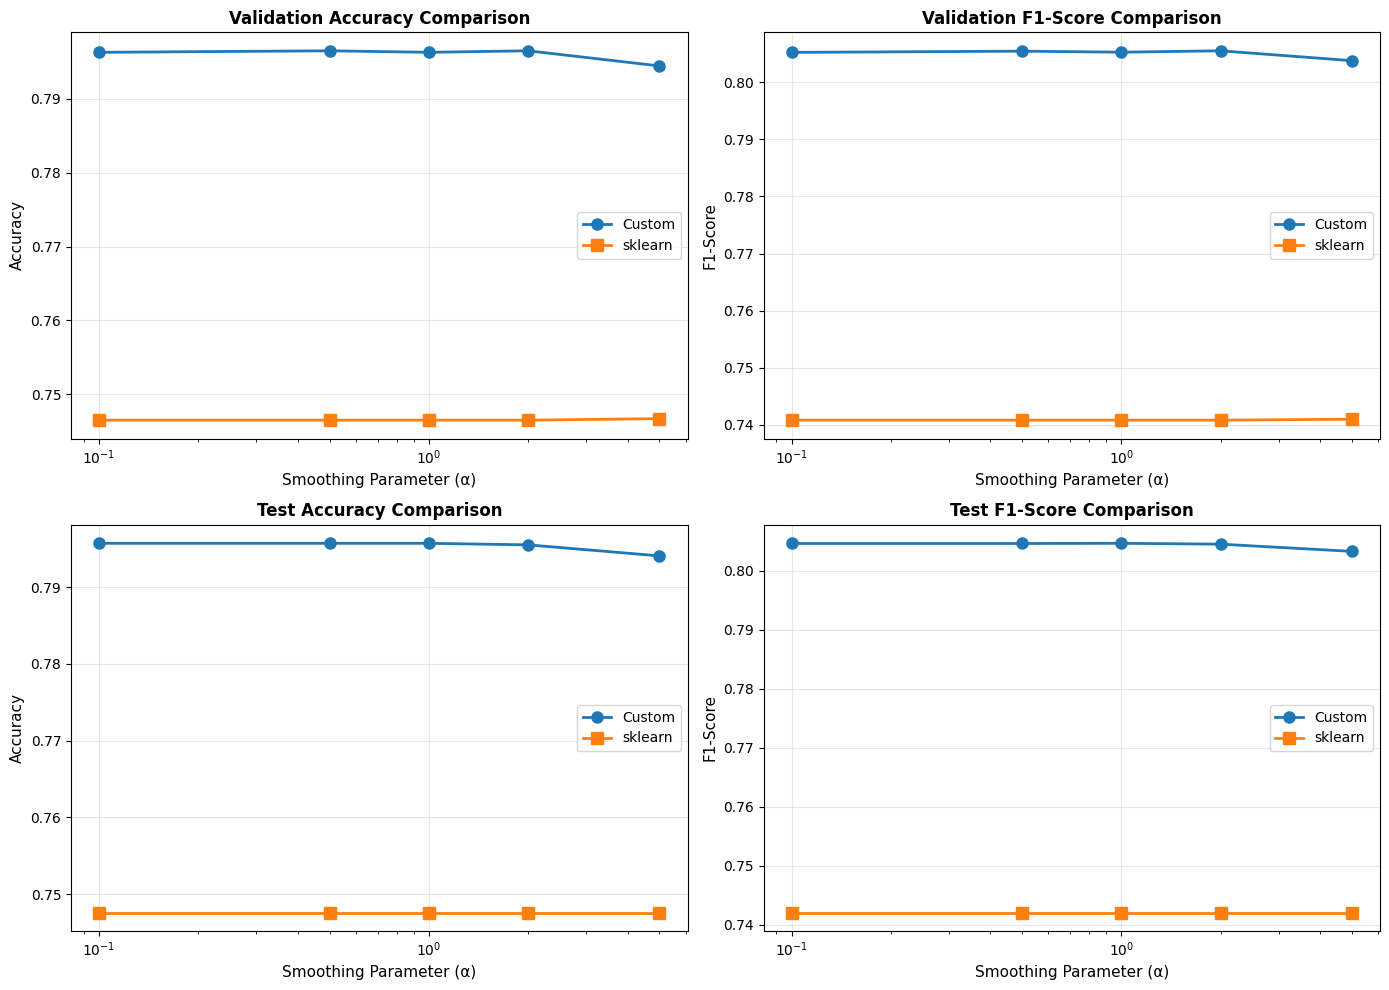


✓ sklearn comparison plot saved!


In [10]:
print("=== Comparison with sklearn's MultinomialNB ===\n")

# Test different alpha values with sklearn
sklearn_results = []

for alpha in alpha_values:
    # sklearn's MultinomialNB
    nb_sklearn = MultinomialNB(alpha=alpha)
    nb_sklearn.fit(X_train, y_train)
    
    # Predictions
    y_pred_val_sklearn = nb_sklearn.predict(X_val)
    y_pred_test_sklearn = nb_sklearn.predict(X_test)
    
    val_acc_sklearn = accuracy_score(y_val, y_pred_val_sklearn)
    val_f1_sklearn = f1_score(y_val, y_pred_val_sklearn, average='weighted')
    test_acc_sklearn = accuracy_score(y_test, y_pred_test_sklearn)
    test_f1_sklearn = f1_score(y_test, y_pred_test_sklearn, average='weighted')
    
    sklearn_results.append({
        'alpha': alpha,
        'val_acc': val_acc_sklearn,
        'val_f1': val_f1_sklearn,
        'test_acc': test_acc_sklearn,
        'test_f1': test_f1_sklearn
    })

sklearn_results_df = pd.DataFrame(sklearn_results)

# Comparison table
print("=== Performance Comparison (α = 1.0) ===\n")
print("Custom Categorical Naïve Bayes vs sklearn's MultinomialNB")
print("-" * 70)

# Custom implementation results for alpha=1.0
custom_idx = results_df[results_df['alpha'] == 1.0].index[0]
custom_val_acc = results_df.loc[custom_idx, 'val_acc']
custom_val_f1 = results_df.loc[custom_idx, 'val_f1']
custom_test_acc = results_df.loc[custom_idx, 'test_acc']
custom_test_f1 = results_df.loc[custom_idx, 'test_f1']

sklearn_idx = sklearn_results_df[sklearn_results_df['alpha'] == 1.0].index[0]
sklearn_val_acc = sklearn_results_df.loc[sklearn_idx, 'val_acc']
sklearn_val_f1 = sklearn_results_df.loc[sklearn_idx, 'val_f1']
sklearn_test_acc = sklearn_results_df.loc[sklearn_idx, 'test_acc']
sklearn_test_f1 = sklearn_results_df.loc[sklearn_idx, 'test_f1']

comparison_data = {
    'Model': ['Custom Implementation', 'sklearn MultinomialNB'],
    'Val_Acc': [custom_val_acc, sklearn_val_acc],
    'Val_F1': [custom_val_f1, sklearn_val_f1],
    'Test_Acc': [custom_test_acc, sklearn_test_acc],
    'Test_F1': [custom_test_f1, sklearn_test_f1]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n=== Full Alpha Comparison ===")
print("\nCustom Implementation:")
print(results_df.to_string(index=False))
print("\nsklearn MultinomialNB:")
print(sklearn_results_df.to_string(index=False))

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Validation Accuracy
axes[0, 0].plot(results_df['alpha'], results_df['val_acc'], 'o-', label='Custom', linewidth=2, markersize=8)
axes[0, 0].plot(sklearn_results_df['alpha'], sklearn_results_df['val_acc'], 's-', label='sklearn', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Smoothing Parameter (α)', fontsize=11)
axes[0, 0].set_ylabel('Accuracy', fontsize=11)
axes[0, 0].set_title('Validation Accuracy Comparison', fontsize=12, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xscale('log')

# Validation F1
axes[0, 1].plot(results_df['alpha'], results_df['val_f1'], 'o-', label='Custom', linewidth=2, markersize=8)
axes[0, 1].plot(sklearn_results_df['alpha'], sklearn_results_df['val_f1'], 's-', label='sklearn', linewidth=2, markersize=8)
axes[0, 1].set_xlabel('Smoothing Parameter (α)', fontsize=11)
axes[0, 1].set_ylabel('F1-Score', fontsize=11)
axes[0, 1].set_title('Validation F1-Score Comparison', fontsize=12, fontweight='bold')
axes[0, 1].legend(fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xscale('log')

# Test Accuracy
axes[1, 0].plot(results_df['alpha'], results_df['test_acc'], 'o-', label='Custom', linewidth=2, markersize=8)
axes[1, 0].plot(sklearn_results_df['alpha'], sklearn_results_df['test_acc'], 's-', label='sklearn', linewidth=2, markersize=8)
axes[1, 0].set_xlabel('Smoothing Parameter (α)', fontsize=11)
axes[1, 0].set_ylabel('Accuracy', fontsize=11)
axes[1, 0].set_title('Test Accuracy Comparison', fontsize=12, fontweight='bold')
axes[1, 0].legend(fontsize=10)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xscale('log')

# Test F1
axes[1, 1].plot(results_df['alpha'], results_df['test_f1'], 'o-', label='Custom', linewidth=2, markersize=8)
axes[1, 1].plot(sklearn_results_df['alpha'], sklearn_results_df['test_f1'], 's-', label='sklearn', linewidth=2, markersize=8)
axes[1, 1].set_xlabel('Smoothing Parameter (α)', fontsize=11)
axes[1, 1].set_ylabel('F1-Score', fontsize=11)
axes[1, 1].set_title('Test F1-Score Comparison', fontsize=12, fontweight='bold')
axes[1, 1].legend(fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xscale('log')

plt.tight_layout()
plt.savefig('sklearn_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ sklearn comparison plot saved!")


# Part C: Decision Tree Implementation

In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from collections import Counter
import random

data = load_breast_cancer()
X, y = data.data, data.target

print(data)

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

print(f"Train set size: {len(X_train)} samples (70%)")
print(f"Validation set size: {len(X_val)} samples (15%)")
print(f"Test set size: {len(X_test)} samples (15%)")

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
        1.189e-01],
       [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
        8.902e-02],
       [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
        8.758e-02],
       ...,
       [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
        7.820e-02],
       [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
        1.240e-01],
       [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
        7.039e-02]]), 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
 

## Entropy and Information Gain
We use Entropy to measure the impurity. For a set of samples $S$ with classes $C$, the entropy is defined as:$$H(S) = - \sum_{c \in C} p(c) \log_2 p(c)$$Where $p(c)$ is the proportion of samples belonging to class $c$.To decide the best split, we calculate the Information Gain (IG). If we split a parent node $S$ into a left child $S_L$ and a right child $S_R$ using a feature threshold, the gain is:$$IG = H(S) - \left( \frac{|S_L|}{|S|} H(S_L) + \frac{|S_R|}{|S|} H(S_R) \right)$$We seek to maximize this value at every split.

In [ ]:
def entropy(y):
    if len(y) == 0:
        return 0
    # Count each class
    counts = Counter(y)
    probabilities = [count / len(y) for count in counts.values()]
    # Entropy formula: -summation(p * log2(p))
    entropy_value = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
    return entropy_value

def information_gain(y_parent, y_left, y_right):
    p = len(y_left) / len(y_parent)
    # IG = H(parent) - [weighted average of children's entropy]
    return entropy(y_parent) - (p * entropy(y_left) + (1 - p) * entropy(y_right))

def majority_vote(y):
    # Find the most common element in y
    return Counter(y).most_common(1)[0][0]

In [ ]:
class Node:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right

        # Leaf Node attribute (used for prediction)
        self.value = value

    # Check if this node is a leaf
    def is_leaf(self):
        return self.value is not None

## Decision Tree Classifier Class

Stopping Criteria: Max depth (max_depth), minimum samples (min_samples_split), or pure nodes.

Max Features Compatibility: It includes max_features logic. For this part, we will use max_features=None (using all features). For the Random Forest, we can switch this to sqrt.

In [ ]:
class DecisionTreeClassifier:
    def __init__(self, max_depth=10, min_samples_split=2, max_features=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features 
        self.root = None

    def fit(self, X, y):
        n_features = X.shape[1]

        # Determine features to consider at each split
        if self.max_features is None:
            self.feature_indices = np.arange(n_features) # All features
        elif isinstance(self.max_features, int):
            self.feature_indices = np.arange(n_features) # Will subsample later
        elif isinstance(self.max_features, float):
             # uses ratio for max features
            self.feature_indices = np.arange(n_features)
        else:
             self.feature_indices = np.arange(n_features)


        self.root = self._grow_tree(X, y, 0)
        return self

    def _grow_tree(self, X, y, depth):
        n_samples, n_features = X.shape
        n_labels = len(np.unique(y))

        # Stopping conditions
        # 1-Reached max depth
        # 2-Samples less than minimum samples to split
        # 3-Pure node
        if (depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split):
            leaf_value = majority_vote(y)
            return Node(value=leaf_value)

        # Find best split
        # If max_features is set we select a random subset of features
        if self.max_features is None:
            feat_indices = self.feature_indices # Use all features
        else:
            # Randomly sample features for this split
            k = int(self.max_features) if isinstance(self.max_features, int) else int(np.sqrt(n_features))
            feat_indices = random.sample(list(self.feature_indices), k)
        
        best_feat, best_thresh = self._best_split(X, y, feat_indices)

        # If no gain found then this is a leaf node
        if best_feat is None:
            return Node(value=majority_vote(y))

        # --- Split Data ---
        left_indices = X[:, best_feat] <= best_thresh
        right_indices = X[:, best_feat] > best_thresh

        X_left, y_left = X[left_indices], y[left_indices]
        X_right, y_right = X[right_indices], y[right_indices]

        # --- Recursive Call ---
        left_child = self._grow_tree(X_left, y_left, depth + 1)
        right_child = self._grow_tree(X_right, y_right, depth + 1)

        return Node(best_feat, best_thresh, left_child, right_child)


    def _best_split(self, X, y, feature_indices):
        max_gain = -1
        best_feat, best_thresh = None, None

        for feat_idx in feature_indices:
            # Use sorted distinct values as candidate thresholds
            thresholds = np.unique(X[:, feat_idx])

            for thresh in thresholds:
                # Split on the threshold: x_j <= t and x_j > t
                left_indices = X[:, feat_idx] <= thresh
                right_indices = X[:, feat_idx] > thresh

                y_left, y_right = y[left_indices], y[right_indices]

                # Ensure split is valid (not empty on one side)
                if len(y_left) == 0 or len(y_right) == 0:
                    continue

                # Compute Information Gain
                current_gain = information_gain(y, y_left, y_right)

                # Update best split if gain is higher
                if current_gain > max_gain:
                    max_gain = current_gain
                    best_feat = feat_idx
                    best_thresh = thresh

        return best_feat, best_thresh

    def predict(self, X):
        #Returns predictions for a list of samples
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_leaf():
            return node.value

        # Check the condition at the internal node
        if x[node.feature_index] <= node.threshold:
            return self._traverse_tree(x, node.left)
        else:
            return self._traverse_tree(x, node.right)

## Hyperparameter Tuning and Evaluation
We perform a grid search over:
max_depth $\in \{2, 4, 6, 8, 10\}$

min_samples_split $\in \{2, 5, 10\}$

We select the best combination based on validation accuracy, retrain on the combined Train+Validation set, and report final metrics on the Test set.


Validation set Evaluation (Depth:2, min_samples_split:2)

Validation Accuracy: 0.9176
Class 0 (Malignant) - Precision: 0.8205, Recall: 1.0000, F1: 0.9014
Class 1 (Benign)    - Precision: 1.0000, Recall: 0.8679, F1: 0.9293

Confusion Matrix:
 [[32  0]
 [ 7 46]]

Validation set Evaluation (Depth:2, min_samples_split:5)

Validation Accuracy: 0.9176
Class 0 (Malignant) - Precision: 0.8205, Recall: 1.0000, F1: 0.9014
Class 1 (Benign)    - Precision: 1.0000, Recall: 0.8679, F1: 0.9293

Confusion Matrix:
 [[32  0]
 [ 7 46]]

Validation set Evaluation (Depth:2, min_samples_split:10)

Validation Accuracy: 0.9176
Class 0 (Malignant) - Precision: 0.8205, Recall: 1.0000, F1: 0.9014
Class 1 (Benign)    - Precision: 1.0000, Recall: 0.8679, F1: 0.9293

Confusion Matrix:
 [[32  0]
 [ 7 46]]

Validation set Evaluation (Depth:4, min_samples_split:2)

Validation Accuracy: 0.9765
Class 0 (Malignant) - Precision: 0.9412, Recall: 1.0000, F1: 0.9697
Class 1 (Benign)    - Precision: 1.0000, Recall: 0.9623, F

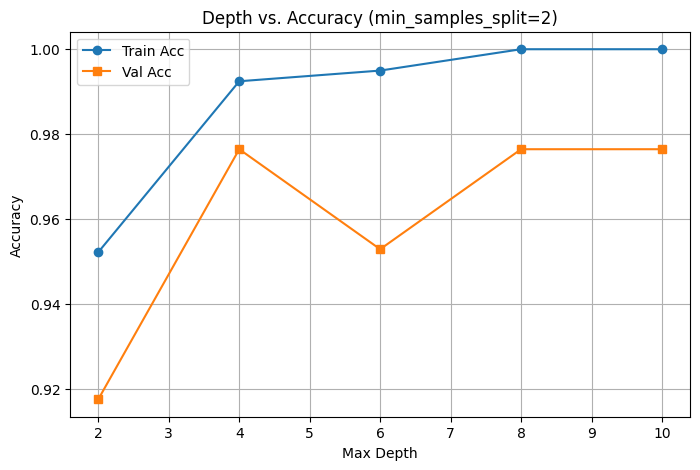


Best parameters found: {'max_depth': 4, 'min_samples_split': 2} with Val Accuracy: 0.9765

--- Final Test Evaluation ---
Test Accuracy: 0.8837
Class 0 (Malignant) - Precision: 0.8667, Recall: 0.8125, F1: 0.8387
Class 1 (Benign)    - Precision: 0.8929, Recall: 0.9259, F1: 0.9091

Confusion Matrix:
 [[26  6]
 [ 4 50]]


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix,classification_report

def train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test):
    max_depths = [2, 4, 6, 8, 10]
    min_samples_splits = [2, 5, 10]
    
    best_accuracy = -1
    best_params = {}
    history = []

    for depth in max_depths:
        for min_samples in min_samples_splits:
            model = DecisionTreeClassifier(
                max_depth=depth, 
                min_samples_split=min_samples, 
                max_features=None
            ).fit(X_train, y_train)

            y_train_pred = model.predict(X_train)
            train_acc = accuracy_score(y_train, y_train_pred)

            y_val_pred = model.predict(X_val)
            val_acc = accuracy_score(y_val, y_val_pred)

            history.append({
                'max_depth': depth,
                'min_samples_split': min_samples,
                'train_acc': train_acc,
                'val_acc': val_acc
            })

            val_precision = precision_score(y_val, y_val_pred, average=None)
            val_recall = recall_score(y_val, y_val_pred, average=None)
            val_f1 = f1_score(y_val, y_val_pred, average=None)
            val_conf_matrix = confusion_matrix(y_val, y_val_pred)

            print(f"\nValidation set Evaluation (Depth:{depth}, min_samples_split:{min_samples})\n")
            print(f"Validation Accuracy: {val_acc:.4f}")
            print(f"Class 0 (Malignant) - Precision: {val_precision[0]:.4f}, Recall: {val_recall[0]:.4f}, F1: {val_f1[0]:.4f}")
            print(f"Class 1 (Benign)    - Precision: {val_precision[1]:.4f}, Recall: {val_recall[1]:.4f}, F1: {val_f1[1]:.4f}")
            print("\nConfusion Matrix:\n", val_conf_matrix)
                    
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = {'max_depth': depth, 'min_samples_split': min_samples}

    print("\nAnalysis effect of Max Depth (fixed min_samples_split=2):")
    history_df = pd.DataFrame(history)
    df = history_df[history_df['min_samples_split'] == 2][['max_depth', 'train_acc', 'val_acc']]
    print(df)
    
    plt.figure(figsize=(8, 5))
    plt.plot(df['max_depth'], df['train_acc'], marker='o', label='Train Acc')
    plt.plot(df['max_depth'], df['val_acc'], marker='s', label='Val Acc')
    plt.xlabel('Max Depth')
    plt.ylabel('Accuracy')
    plt.title('Depth vs. Accuracy (min_samples_split=2)')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nBest parameters found: {best_params} with Val Accuracy: {best_accuracy:.4f}")
    
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.hstack((y_train, y_val))
    
    final_model = DecisionTreeClassifier(
        max_depth=best_params['max_depth'], 
        min_samples_split=best_params['min_samples_split'],
        max_features=None
    ).fit(X_train_val, y_train_val)

    y_test_pred = final_model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, y_test_pred)
    test_precision = precision_score(y_test, y_test_pred, average=None)
    test_recall = recall_score(y_test, y_test_pred, average=None)
    test_f1 = f1_score(y_test, y_test_pred, average=None)
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    print("\n--- Final Test Evaluation ---")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Class 0 (Malignant) - Precision: {test_precision[0]:.4f}, Recall: {test_recall[0]:.4f}, F1: {test_f1[0]:.4f}")
    print(f"Class 1 (Benign)    - Precision: {test_precision[1]:.4f}, Recall: {test_recall[1]:.4f}, F1: {test_f1[1]:.4f}")
    print("\nConfusion Matrix:\n", conf_matrix)
    
    return history, final_model

history, final_dt_model = train_and_evaluate(X_train, y_train, X_val, y_val, X_test, y_test)

## Analysis and Evaluation
1. Tree Complexity and Overfitting Analysis

Relationship between Depth and Performance:

We observed that as max_depth increases, the training accuracy typically increases (approaching 100% at high depths). However, the validation accuracy usually peaks at a moderate depth (e.g., depth 4 or 6) and then plateaus or decreases.

* Low Depth (e.g., 2): The model suffers from high bias (underfitting). It cannot capture the complex boundaries between malignant and benign samples.

* High Depth (e.g., 10): The model suffers from high variance (overfitting). It begins to memorize noise in the training data, which fails to generalize to the validation set.

2. Confusion Matrix Analysis

The confusion matrix provides insight into the types of errors made:$$\begin{bmatrix}
TP & FN \\
FP & TN
\end{bmatrix}$$In the context of breast cancer diagnosis (Malignant=0 vs Benign=1):
* False Negatives : Classifying a Malignant tumor as Benign. This is the most critical error in a medical context, as a sick patient might go untreated.
* False Positives : Classifying a Benign tumor as Malignant. This causes unnecessary stress and biopsies but is generally less fatal than a False Negative.
3. Feature Importance

Feature importance in decision trees is determined by how much Information Gain a feature provides.The feature at the root node (depth 0) is the most important feature globally, as it provides the highest initial reduction in entropy.

Features used near the top of the tree contribute more to the decision-making process than those used only in deep leaves

Observation based on data: Typically, features like mean concave points, worst radius, or worst perimeter are often selected as the root split for this dataset.

4. Hyperparameter Selection

Based on our grid search on the validation set, the optimal configuration was max_depth = 4 and min_samples_split = 2. This combination provided the best balance, minimizing the total error rate on unseen data while avoiding the complexity of a fully grown tree.

----------------------------------------------------------------------------

# Part D Random Forest


Validation set Evaluation (No. of Trees:5, Max Features:5)

Validation Accuracy: 0.9529
Class 0 (Malignant) - Precision: 0.8889, Recall: 1.0000, F1: 0.9412
Class 1 (Benign)    - Precision: 1.0000, Recall: 0.9245, F1: 0.9608

Confusion Matrix:
 [[32  0]
 [ 4 49]]

Validation set Evaluation (No. of Trees:5, Max Features:15)

Validation Accuracy: 0.9647
Class 0 (Malignant) - Precision: 0.9394, Recall: 0.9688, F1: 0.9538
Class 1 (Benign)    - Precision: 0.9808, Recall: 0.9623, F1: 0.9714

Confusion Matrix:
 [[31  1]
 [ 2 51]]

Validation set Evaluation (No. of Trees:10, Max Features:5)

Validation Accuracy: 0.9765
Class 0 (Malignant) - Precision: 0.9688, Recall: 0.9688, F1: 0.9688
Class 1 (Benign)    - Precision: 0.9811, Recall: 0.9811, F1: 0.9811

Confusion Matrix:
 [[31  1]
 [ 1 52]]

Validation set Evaluation (No. of Trees:10, Max Features:15)

Validation Accuracy: 0.9765
Class 0 (Malignant) - Precision: 0.9412, Recall: 1.0000, F1: 0.9697
Class 1 (Benign)    - Precision: 1.0000, Recall

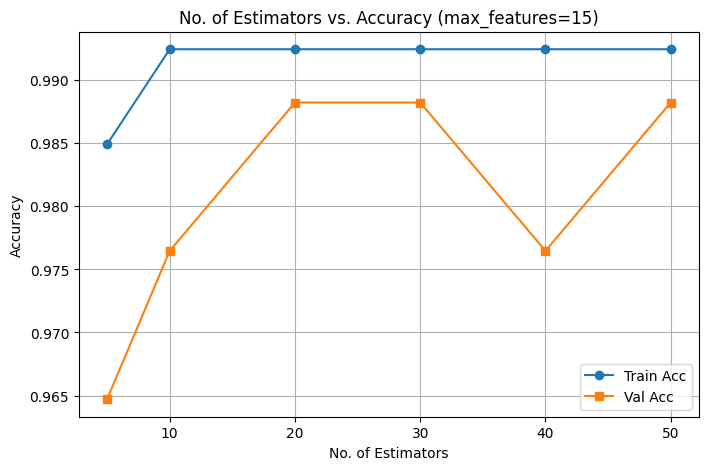


Best RF parameters: T=20, max_features=15 with Val Accuracy: 0.9882

--- Final Random Forest Test Evaluation ---
Test Accuracy: 0.8953
Precision: 0.8956
Recall:    0.8785
F1 Score:  0.8857

Confusion Matrix:
 [[26  6]
 [ 3 51]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.81      0.85        32
           1       0.89      0.94      0.92        54

    accuracy                           0.90        86
   macro avg       0.90      0.88      0.89        86
weighted avg       0.90      0.90      0.89        86



In [ ]:
BEST_MAX_DEPTH = 4 
BEST_MIN_SAMPLES_SPLIT = 2


class RandomForestClassifier:
    def __init__(self, n_estimators=10, max_features=5, max_depth=None, min_samples_split=2):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.trees = []

    def fit(self, X, y):
        self.trees = []
        n_samples = X.shape[0]

        for _ in range(self.n_estimators):
            # 1. Bootstrap Sampling (Sampling with replacement)
            # Create indices for the bootstrap sample
            # size=n_samples is used to create a sample the same size as the training set
            bootstrap_indices = np.random.choice(n_samples, size=n_samples, replace=True)
            X_sample, y_sample = X[bootstrap_indices], y[bootstrap_indices]
            
            # 2. Train Decision Tree with Feature Subsampling
            tree = DecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=self.max_features # Use max_features for feature subsampling
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
        
        return self

    def predict(self, X):
        # Collect predictions from all trees
        tree_predictions = np.array([tree.predict(X) for tree in self.trees])
        
        # 3. Majority Voting:
        # Transpose to get (n_samples, n_estimators)
        tree_predictions = tree_predictions.T
        
        # For each sample, find the most frequent prediction
        final_predictions = np.array([majority_vote(preds) for preds in tree_predictions])
        return final_predictions

# --- Tuning and Evaluation Function for Random Forest ---

def tune_and_evaluate_rf(X_train, y_train, X_val, y_val, X_test, y_test, max_depth, min_samples_split):
    
    n_estimators_grid = [5, 10, 20, 30, 40, 50]
    # d=30 features: sqrt(d)=5, d/2=15
    max_features_grid = [5, 15] 
    
    best_accuracy = -1
    best_params = {}
    tuning_history = []
    
    for T in n_estimators_grid:
        for max_feat in max_features_grid:
            rf_model = RandomForestClassifier(
                n_estimators=T,
                max_features=max_feat,
                max_depth=max_depth,
                min_samples_split=min_samples_split
            )
            rf_model.fit(X_train, y_train)

            y_train_pred = rf_model.predict(X_train)
            train_acc = accuracy_score(y_train, y_train_pred)
            
            y_val_pred = rf_model.predict(X_val)
            val_acc = accuracy_score(y_val, y_val_pred)
            
            tuning_history.append({
                'T': T, 
                'max_features': max_feat,
                'train_acc': train_acc,
                'val_acc': val_acc
            })

            val_precision = precision_score(y_val, y_val_pred, average=None)
            val_recall = recall_score(y_val, y_val_pred, average=None)
            val_f1 = f1_score(y_val, y_val_pred, average=None)
            val_conf_matrix = confusion_matrix(y_val, y_val_pred)

            print(f"\nValidation set Evaluation (No. of Trees:{T}, Max Features:{max_feat})\n")
            print(f"Validation Accuracy: {val_acc:.4f}")
            print(f"Class 0 (Malignant) - Precision: {val_precision[0]:.4f}, Recall: {val_recall[0]:.4f}, F1: {val_f1[0]:.4f}")
            print(f"Class 1 (Benign)    - Precision: {val_precision[1]:.4f}, Recall: {val_recall[1]:.4f}, F1: {val_f1[1]:.4f}")
            print("\nConfusion Matrix:\n", val_conf_matrix)
            
            if val_acc > best_accuracy:
                best_accuracy = val_acc
                best_params = {'T': T, 'max_features': max_feat}

    df_tuning = pd.DataFrame(tuning_history)
    print("Tuning Results:")
    print(df_tuning)

    print("\nAnalysis effect of No. of Estimators (fixed max_features=15):")
    df = df_tuning[df_tuning['max_features'] == 15][['T', 'train_acc', 'val_acc']]

    plt.figure(figsize=(8, 5))
    plt.plot(df['T'], df['train_acc'], marker='o', label='Train Acc')
    plt.plot(df['T'], df['val_acc'], marker='s', label='Val Acc')
    plt.xlabel('No. of Estimators')
    plt.ylabel('Accuracy')
    plt.title('No. of Estimators vs. Accuracy (max_features=15)')
    plt.legend()
    plt.grid(True)
    plt.show()

    print(f"\nBest RF parameters: T={best_params['T']}, max_features={best_params['max_features']} with Val Accuracy: {best_accuracy:.4f}")

    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.hstack((y_train, y_val))
    
    final_rf_model = RandomForestClassifier(
        n_estimators=best_params['T'], 
        max_features=best_params['max_features'],
        max_depth=max_depth,
        min_samples_split=min_samples_split
    )
    final_rf_model.fit(X_train_val, y_train_val) 

    y_test_pred = final_rf_model.predict(X_test)
    
    test_accuracy = accuracy_score(y_test, y_test_pred)

    test_precision = precision_score(y_test, y_test_pred, average='macro') 
    test_recall = recall_score(y_test, y_test_pred, average='macro')
    test_f1 = f1_score(y_test, y_test_pred, average='macro')
    test_conf_matrix = confusion_matrix(y_test, y_test_pred)

    print("\n--- Final Random Forest Test Evaluation ---")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Precision: {test_precision:.4f}")
    print(f"Recall:    {test_recall:.4f}")
    print(f"F1 Score:  {test_f1:.4f}")
    print("\nConfusion Matrix:\n", test_conf_matrix)
    print("\nClassification Report:\n", classification_report(y_test,y_test_pred))
    
    return final_rf_model

final_rf_model = tune_and_evaluate_rf(
    X_train, y_train, X_val, y_val, X_test, y_test,
    BEST_MAX_DEPTH, BEST_MIN_SAMPLES_SPLIT
)

### 1. Single Decision Tree (High Variance)
A single DT, even when optimally pruned (restricted to max_depth=4), is inherently a high-variance model.

* High Variance: The tree structure is highly sensitive to small perturbations in the training data (due to the recursive greedy search for the best split). This leads to an unstable model, where training accuracy is high, but performance drops significantly on unseen data (test set), indicating overfitting noise in the training set.
### 2. Random Forest (Reduced Variance)
The Random Forest significantly mitigates the high variance problem through two mechanisms: Bagging and Feature Subsampling.
##### Reduced Variance via Bagging: 
By training multiple trees on independent bootstrap samples and averaging their results (majority vote), the forest cancels out the high variance of the individual trees. This stabilizes the overall prediction, allowing the model to generalize better.
##### Reduced Correlation via Feature Subsampling: 
Forcing each tree to select only a random subset of features ($\lfloor\sqrt{d}\rfloor$ or $\lfloor d/2\rfloor$) at every split ensures that the trees are decorrelated. If one feature is overwhelmingly dominant, feature subsampling prevents it from being used at the root of every tree, forcing the forest to explore alternative decision boundaries and ensuring diversity.
##### Low Bias Maintained: 
Since the base trees are allowed to grow to the optimal depth ($\text{max\_depth}=4$), they retain the necessary power to capture the underlying non-linear patterns (low bias).
#### Conclusion:
The Random Forest architecture effectively combines multiple low-bias, high-variance estimators into a final ensemble that maintains low bias while successfully achieving low variance, leading to a much more robust and accurate model compared to the single Decision Tree.